In [25]:
#restart the kernel if switching from inline to notebook
import matplotlib.pyplot as plt
%matplotlib notebook 
plt.style.use('seaborn-whitegrid')
import corner

import numpy as np
import numpy.linalg
import scipy.stats
from scipy.signal import argrelextrema
import pandas as pd

import emcee
import george

from subsample import subsample # daniela's code
from emcee_utils import walker_params, plot_gpfit
#from plotting import plot_steps
from plotting import plot_lightcurve, plot_folded_lightcurve, plot_mcmc_sampling_results, plot_steps

In [26]:
txt = "lightcurve_6478_2005_04_03_and_2019_02_09_oringinal_date_mjd_utc_mag_mag_unc_all_mags_converted_to_r_light_time_and_geometry_corrected.txt"
data = pd.read_csv(txt, delim_whitespace=True, header=None)

In [31]:
data.head()

,0,1,2
0,53463.280132,14.349831,0.005213
1,53463.284334,14.324832,0.018947
2,53463.287679,14.307932,0.018913
3,53463.290850,14.244732,0.018973
4,53463.297690,14.209332,0.019005


In [87]:
data.tail()

,0,1,2
20,58523.367367,14.206360,0.005701
21,58523.369246,14.235199,0.009068
22,58523.372688,14.239699,0.009483
23,58523.374445,14.277129,0.006438
24,58523.381627,14.325399,0.009828


In [28]:
tsample = data[0]
fsample = data[1]
flux_err = data[2]

<IPython.core.display.Javascript object>


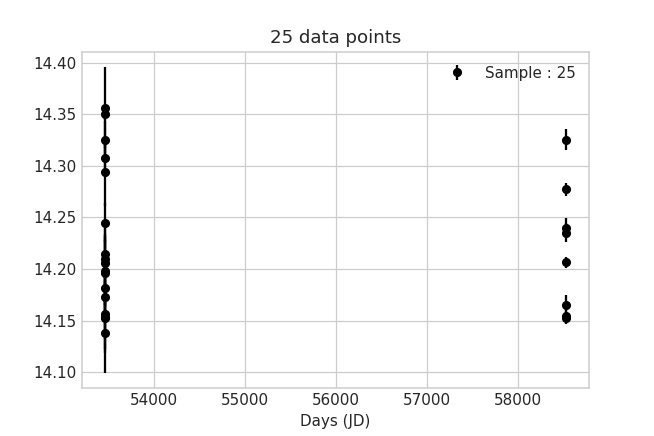

In [29]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title("%i data points"%(len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10, 
            label="Sample : " + str(len(tsample)))
ax.legend()

In [35]:
(tsample.iloc[-1]-tsample[0])

5060.1014944526105

In [50]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 40)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.norm(17.75, 0.5).logpdf(params[0])
    #p_log_amp = scipy.stats.uniform(-10,30).logpdf(params[1])
    p_log_amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf(params[1])
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    ###print this line to get the prob value: p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    #p_period = scipy.stats.uniform(np.log(1./24.), -np.log(1./24.)).logpdf((params[3]))
    #p_period = scipy.stats.halfnorm(loc=np.log(0.5/24.), scale=np.exp(0.5/24.)).logpdf(params[3])
    #p_period = scipy.stats.halfcauchy(loc=np.log(0.5/24.), scale=np.exp(0.5/24.)).logpdf(params[3])
    p_period = scipy.stats.norm(np.log(4./24.), (12./24.)).logpdf(params[3])
    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior

def logl(params, gp, tsample, fsample, flux_err):
    # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)

    try:
        gp.compute(tsample, flux_err)
        lnlike = gp.lnlikelihood(fsample)
    except np.linalg.LinAlgError:
        lnlike = -1e25
    return lnlike

def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25

In [51]:
ndim, nwalkers = 4, 100

In [52]:
# initialize walker parameters
gp_mean = np.mean(fsample)
log_amp = np.log(fsample.max()-fsample.min())
gamma = 1
log_period = np.log(0.5)

params = [np.mean(fsample), log_amp, gamma, log_period]

# set up gp kernel
kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
gp.compute(tsample, flux_err)

# equally distributed starting period values
p_start = np.array(params)/100.
cov_matrix = np.sqrt(np.diag(p_start)**2)
p0 = np.random.multivariate_normal(mean=params, cov=cov_matrix, size=(nwalkers))
x = np.log(np.linspace(2,12,nwalkers)/24.)
p0[:,3] = x


In [53]:
threads=4
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[gp, tsample, fsample, flux_err], threads=threads)

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


In [54]:
%%time
mcmc_sampling = sampler.run_mcmc(p0, 50000)

CPU times: user 17min 44s, sys: 1min 38s, total: 19min 22s
Wall time: 2h 21min 46s


<IPython.core.display.Javascript object>


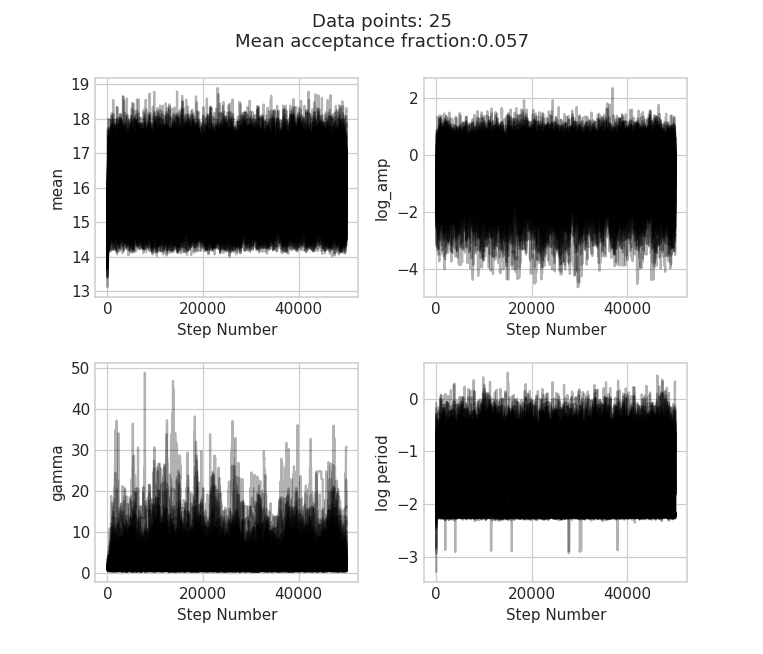

In [55]:
plot_steps(sampler, dims = ['mean', 'log_amp', 'gamma', 'log period'], p0=[params], data_pts=len(fsample))

In [92]:
np.quantile(periods,0.05)*24

2.618316476181189

<IPython.core.display.Javascript object>


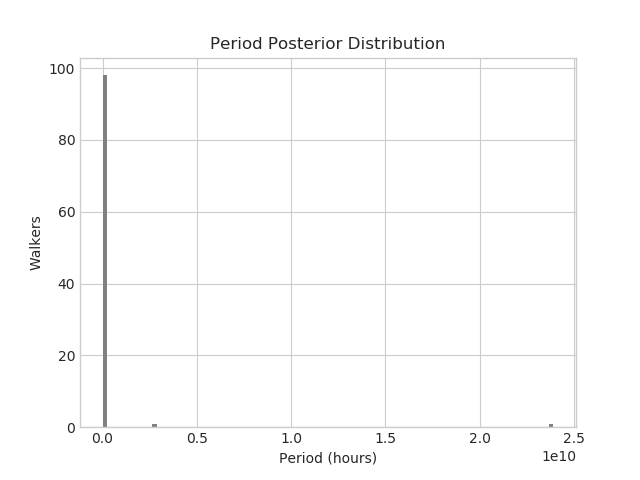

Text(0.5,0,'Period (hours)')

In [93]:
# sampler.chain[chain, step, dimension]
end_period = sampler.chain[:,-1,-1]
end_period.sort()

fig, fx = plt.subplots(1,1)
fx.hist(np.exp(end_period)*24., bins=100, color='grey')
fx.set_title('Period Posterior Distribution')
fx.set_ylabel('Walkers')
fx.set_xlabel('Period (hours)')

<IPython.core.display.Javascript object>


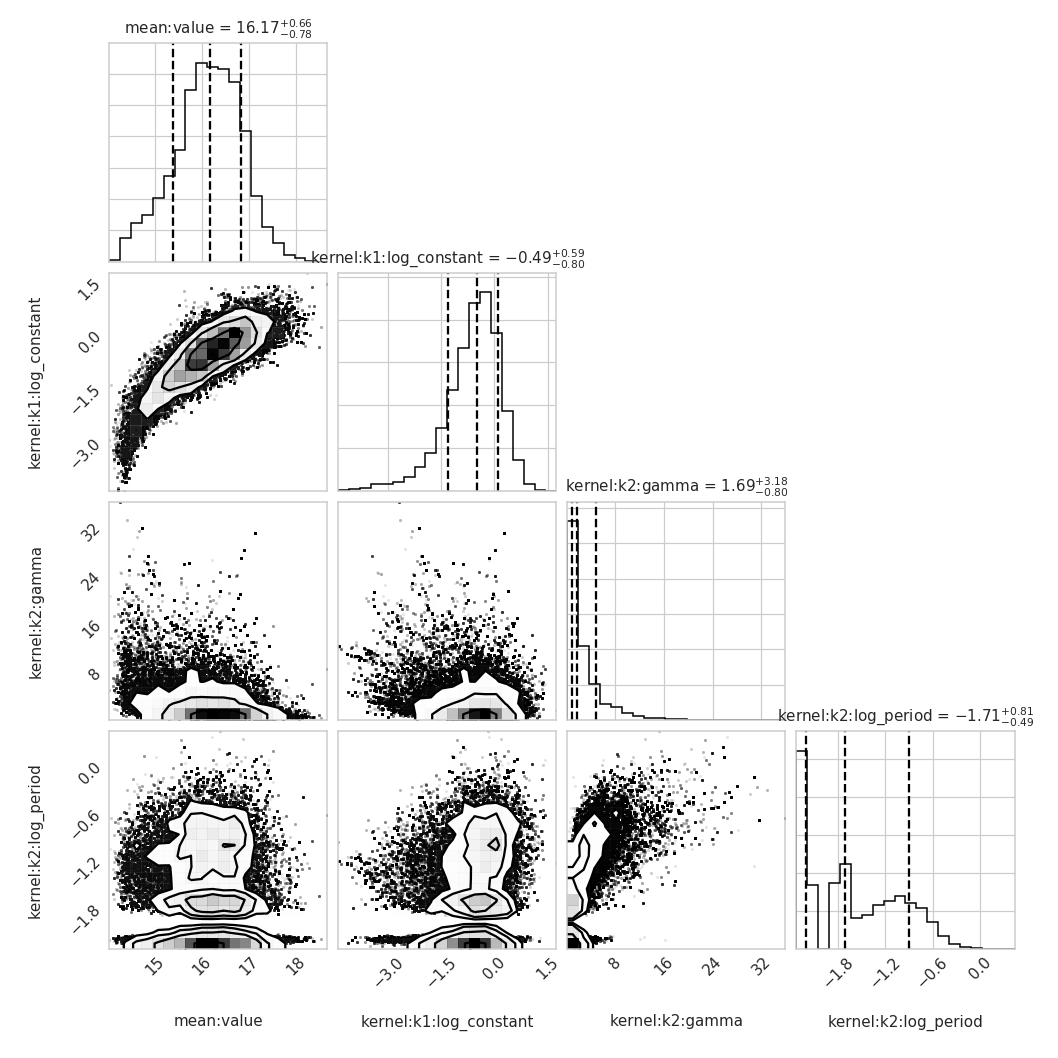

In [57]:
# make some labels
labels = list(gp.get_parameter_names())
#labels[3] = 'period'

# percentage of steps to plot
percent = 0.1

# generate list of last steps spanning backwards
x = list(range(-1,-int(sampler.iterations*percent)-1,-1))

# only plot x last steps
# reshape into 2d array instead of 3d
#sampler.chain[walker, step, param]
figure = corner.corner(sampler.chain[:,x,:].reshape(int(sampler.iterations*percent*sampler.k),4), 
                       labels=labels, quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 10})

The distribution of periods ended up looking like this.

<IPython.core.display.Javascript object>


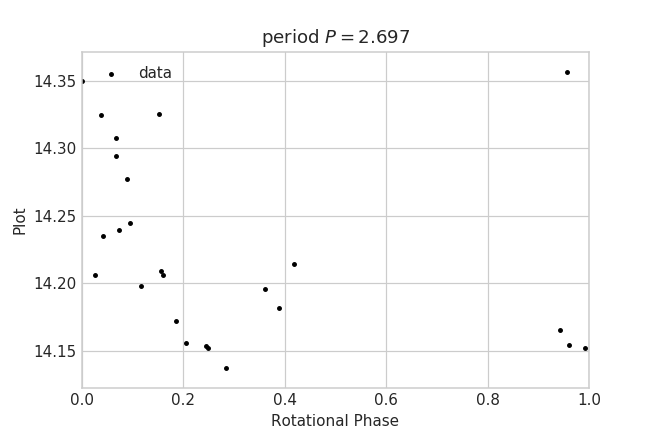

In [67]:
periods = np.exp(sampler.chain[:,-1,-1])
best_period = np.quantile(periods,0.25)
plot_folded_lightcurve(tsample, fsample, best_period)

We can now see how the different posterior distributions model the original sampled data. Feel free to give the file names **namestr** an appropriate title.

In [ ]:
def save_chain(file_name, sampler):
        header = str(sampler.chain.shape)
        np.savetxt(file_name, sampler.flatchain, header=header)
        return

filename = "5318_new_priors"

save_chain(filename + "_results.txt", sampler)

In [99]:
def plot_mcmc_sampling_results(tsample, fsample, flux_err, gp, sampler,
                          t_pred=None, true_lightcurve=None,
                          true_period=None, namestr="test",
                          nmodels=10, npred=1000):


    new_samples = sampler.flatchain
    
    

    ### plot light curve with example models ###
    
    # first, get the total number of available samples
    nsamples = new_samples.shape[0]

    # get some random samples from the
    idx = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nmodels)

    # if the array for the predictions isn't given, make one
    if t_pred is None:
        t_pred = np.linspace(tsample[0], tsample[-1], npred)

    # empty array for output
    m_all = np.zeros((nmodels, t_pred.shape[0]))

    # loop through the indices of samples, for each sample from the GP
    # conditional on the data points
    for i,j in enumerate(idx):
        p = new_samples[j]
        print(p)
        pnew = [p[0], p[1], p[2], p[3]]

        gp.set_parameter_vector(pnew)
        mean_model = gp.sample_conditional(fsample, t_pred)
        m_all[i] = mean_model

    fig, ax = plt.subplots(1, 1, figsize=(6,4))

    plot_lightcurve(tsample, fsample, true_lightcurve=true_lightcurve,
                        models=(t_pred, m_all), ax=ax)

    plt.tight_layout()
    plt.savefig(namestr + "_lc.pdf", format="pdf")

    
    
    ### plot histogram of periods ###
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    ax.hist(np.exp(new_samples[:,-1])*24, bins=100, density=True,
                label="posterior PDF", color="black", alpha=0.5)

    if true_period is not None:
        ylim = ax.get_ylim()
        ax.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))

    ax.set_xlabel("Period in hours")
    ax.set_ylabel("Probability")
    ax.legend()

    plt.tight_layout()
    plt.savefig(namestr + "_period_pdf.pdf", format="pdf")

    
    
    ### plot folded light curve ###

    fig, ax = plt.subplots(1, 1, figsize=(6,4))

    if true_period:
        ax = plot_folded_lightcurve(tsample, fsample, true_period/24., flux_err=0.01,
                          models=[t_pred, m_all[:2]],
                          true_lightcurve=true_lightcurve, ax=ax, use_radians=False)
    else:
        guess_period = np.quantile(np.exp(sampler.chain[:,-1,-1]), 0.1)
        ax = plot_folded_lightcurve(tsample, fsample, guess_period, flux_err=flux_err,
                          models=[t_pred, m_all[:2]],
                          true_lightcurve=true_lightcurve, ax=ax, use_radians=False)

    plt.tight_layout()
    plt.savefig(namestr + "_folded_lc.pdf", format="pdf")


    # convert period values from log days to hours
    x = (np.exp(new_samples.T[3])*24.)
    new_samples.T[3] = x

    labels = list(gp.get_parameter_names())
    labels[3] = 'period hours'

    
    
    ### make a corner plot ###
    
    # percentage of steps to plot
    percent = 0.1

    # generate list of last steps spanning backwards
    x = list(range(-1,-int(sampler.iterations*percent)-1,-1))

    # only plot x last steps
    # reshape into 2d array instead of 3d
    #sampler.chain[walker, step, param]
    figure = corner.corner(sampler.chain[:,x,:].reshape(int(sampler.iterations*percent*sampler.k),4), 
                           labels=labels, quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 10})
    plt.savefig(namestr + "_corner.pdf", format="pdf")

    
    
    ### plot trace plot ###
    
    ax = plot_steps(sampler, dims = ['mean', 'log_amp', 'gamma', 'period'], data_pts=len(fsample))
    plt.savefig(namestr + "_trace.pdf", format="pdf")


[17.40638918  0.19274499  0.74903183 -1.77029723]
[15.48424371 -1.16363937  8.97134872 -0.16405621]
[ 1.68230974e+01  1.07711861e-02  2.76695354e+00 -1.13806523e+00]
[15.83885966 -0.21440571  9.79644207 -0.85270948]
[16.61563862 -0.07850939  1.14288318 -1.81072752]
[16.01798766  0.12235379  3.0131678  -0.85457494]
[16.02919872  0.03003831  0.70741778 -1.76218828]
[15.47566546 -0.67648054  1.16435371 -2.18404239]
[16.44802171 -0.51995884  4.01736253 -0.73740159]
[17.02952596 -0.33032614  0.67205128 -2.17330515]


<IPython.core.display.Javascript object>


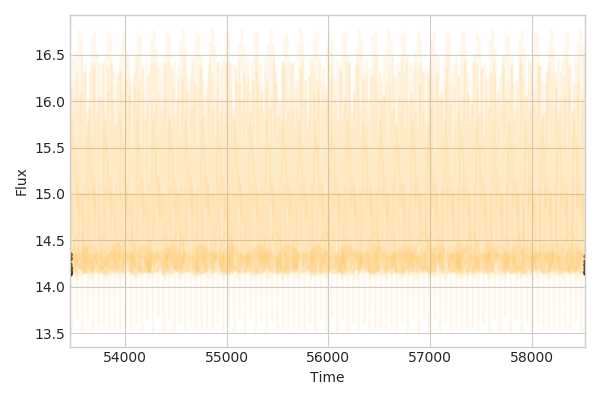

<IPython.core.display.Javascript object>


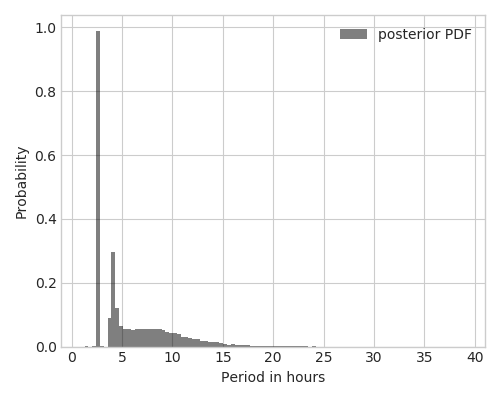

<IPython.core.display.Javascript object>


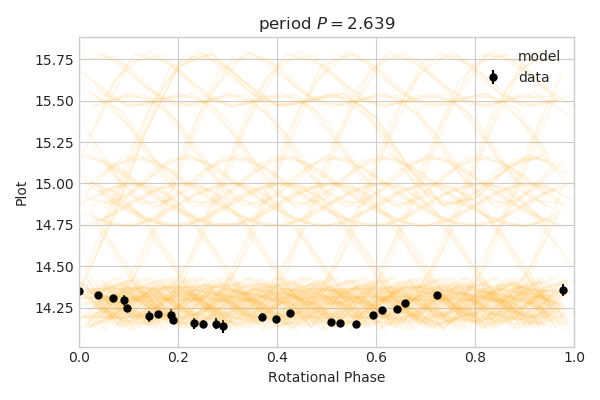

<IPython.core.display.Javascript object>


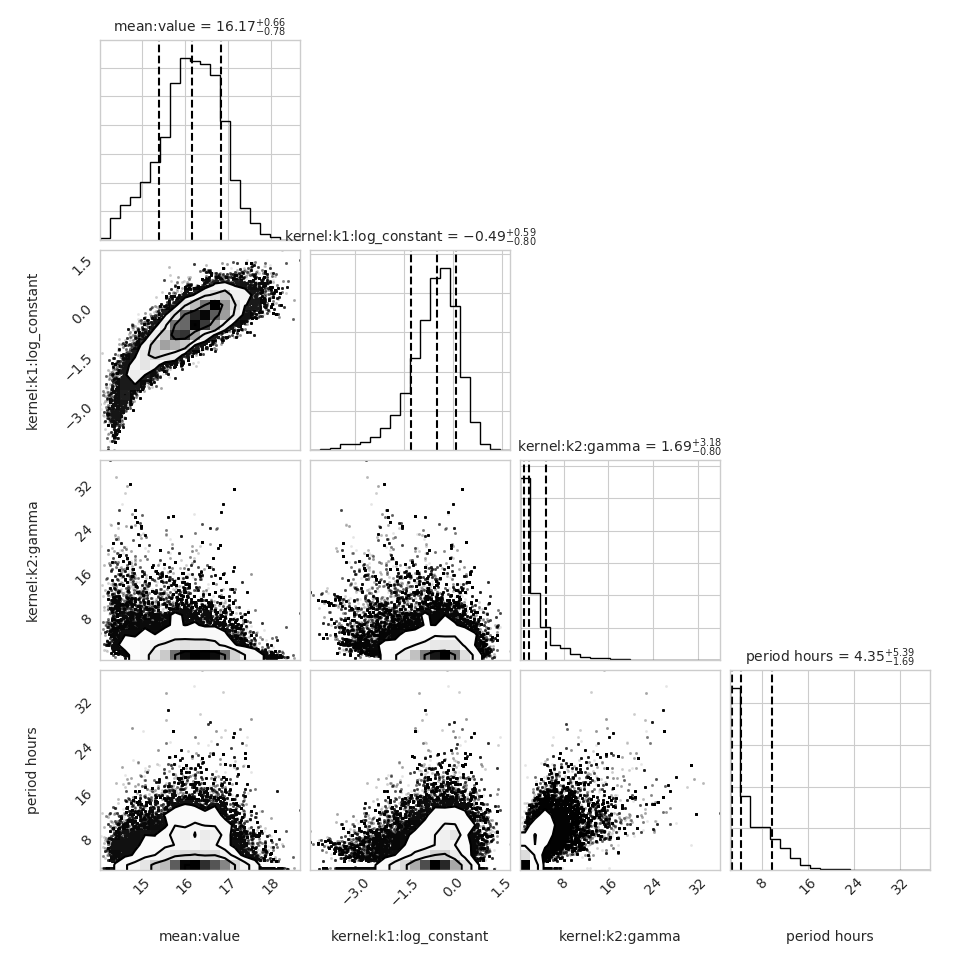

<IPython.core.display.Javascript object>


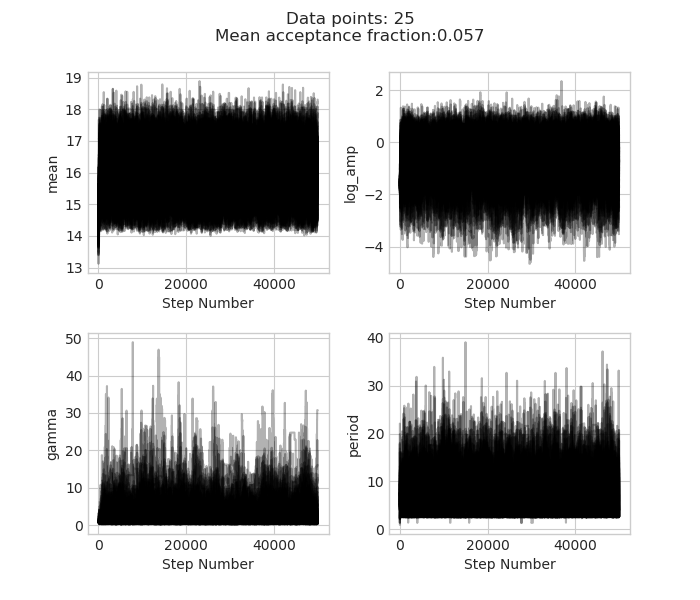

In [102]:
plot_mcmc_sampling_results(np.array(tsample), fsample, flux_err, gp, sampler, 
                           namestr="6478_2005+201" + "_plots", true_lightcurve=None, 
                           true_period=None)

###test failure with plotting if steps are too few

In [100]:
#x = (np.exp(new_samples.T[3])*24.)
x = np.log(sampler.flatchain.T[3]/24.)
x

array([-3.28906592, -3.28906592, -2.36976787, ..., -1.83014636,
       -1.83014636, -0.14695368])

In [107]:
np.exp(-1.76218828)*24.

4.120051034700506

In [101]:
sampler.flatchain.T[3] =x
sampler.flatchain.T[3]

array([-3.28906592, -3.28906592, -2.36976787, ..., -1.83014636,
       -1.83014636, -0.14695368])

In [103]:
import gp_sandbox as cgp

<IPython.core.display.Javascript object>


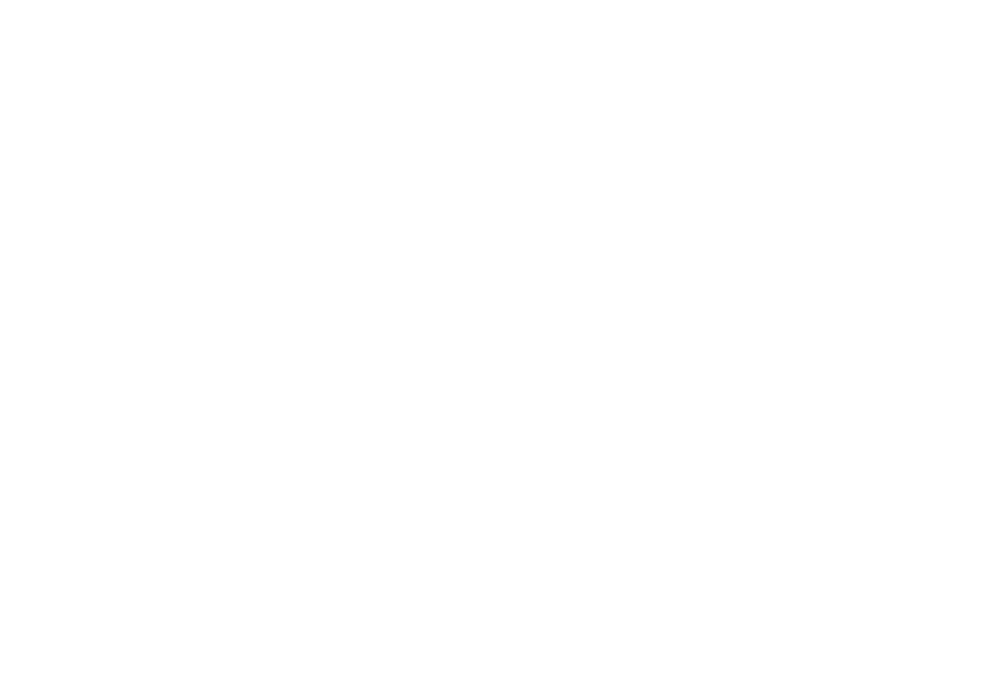

<bound method GP.lnlikelihood of <george.gp.GP object at 0x7f4e54519550>>       fun: -50.32152711061811
 hess_inv: array([[ 2.84536490e-03,  2.66280708e-03, -1.24755177e-02,
         4.58597251e-10],
       [ 2.66280708e-03,  5.53934873e-01, -9.13719967e-01,
        -6.66147934e-10],
       [-1.24755177e-02, -9.13719967e-01,  3.39638737e+00,
         4.00870948e-09],
       [ 4.58597251e-10, -6.66147934e-10,  4.00870948e-09,
         6.75549033e-14]])
      jac: array([1.61571847e-06, 1.31556953e-07, 2.71257861e-09, 8.73037316e-02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 236
      nit: 34
     njev: 215
   status: 2
  success: False
        x: array([14.27428297, -5.00164128,  3.23182202, -2.17330491]) 50.32152711061811


In [109]:
#import file into a pandas dataframe
df = pd.read_csv('../data/1291_lc_49627_to_49787.txt', delimiter=' ',header=None, names=['x','y'], dtype={'x':float, 'y':float})
pre_x = (df.x)
pre_y = df.y

cap = 1000

#sample only from the first 2000 points for x and y (out of 400,000ish...)
x, y, yerr = tsample, fsample, flux_err#cgp.sample_data(pre_x[0:cap], pre_y[0:cap], 1 , 0, 0, 1)  

#plot the two original points
plt.figure(figsize=(10, 7))
#plt.plot(pre_x[0:cap], pre_y[0:cap],  '.', alpha=0.5,label="Original")
plt.errorbar(x,y, yerr, alpha=0.8, fmt='.',label="data points")

#guess the kernel numbers 

#17.84250562 -3.75895736  4.09087516 -2.21950288
##16.02919872  0.03003831  0.70741778 -1.76218828
#17.02952596 -0.33032614  0.67205128 -2.17330515
kernel = np.exp(-0.33032614)*george.kernels.ExpSine2Kernel(gamma=0.67205128, log_period=-2.17330515) #optimal gamma was ~15
gp = george.GP(kernel, fit_mean=True, mean=17.02952596)
gp.compute(x,yerr)
pred, pred_var = gp.predict(y, x, return_var=True)

#plot the kernel-fitted guess
#plt.fill_between(x, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="grey", alpha=0.4)
#plt.plot(x, pred, lw=1.5, alpha=0.7, label="Before")

x_short = np.linspace(x[0], x.iloc[-1], 100000)

#optimize the fit
gp2, ln_like2, result = cgp.optimize(y,gp,gp.lnlikelihood, print_results=True)
pred, pred_var = gp2.predict(y, x_short, return_var=True)

plt.fill_between(x_short, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="grey", alpha=0.4)
plt.plot(x_short, pred, "grey", lw=1.5, alpha=0.5, label="posterior credible intervals")
#plt.xlim([pre_x[0], pre_x[cap]])
plt.legend()

plt.savefig("6478" + "_plot_function_space.pdf", format="pdf")